In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image
from pycocotools.coco import COCO
from scipy.special import expit as sigmoid
import torch
from torchvision import transforms
import torchvision.models as models

from Dataset import MakeSquare
from Misc import im_format

run_search = False

In [2]:
# Setup COCO
coco = COCO('/home/gregory/Datasets/COCO/annotations/instances_val2017.json')
cats = coco.loadCats(coco.getCatIds())

def getClassName(classID, cats = cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def getClassID(name, cats = cats):
    for i in range(len(cats)):
        if cats[i]['name']==name:
            return cats[i]['id']
    return "None"

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [3]:
# Load and configure the model
model_choice = 1
if model_choice == 0:
    model = models.resnet18(pretrained = True)
    model.fc = torch.nn.Linear(in_features = 512, out_features = 91)
elif model_choice == 1:
    model = models.mobilenet_v2(pretrained = True)
    model.classifier[1] = torch.nn.Linear(in_features = 1280, out_features = 91)  
model.load_state_dict(torch.load('./model_transfer.pt'))
model.eval()
model.cuda()

def predict(im, model = model):
    if len(im.size()) == 3:
        im = torch.unsqueeze(im, 0)
    return sigmoid(model(im.cuda()).cpu().data.numpy())

def top_k(im, model = model, k = 3):
    pred = predict(im)[0]
    top =  pred.argsort()[-k:][::-1]
    for i in top:
        v = pred[i]
        name = getClassName(i)
        print(name, v) 
        


In [4]:
# Setup the data loading and modifying

transform = transforms.Compose([
    MakeSquare(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def load_img(img_obj, mask_apply = False, mask_classes = None, mask_mode = 'box', mask_unmask = True, coco = coco, transform = transform):
    img = Image.open('/home/gregory/Datasets/COCO/val2017/' + img_obj['file_name']).convert('RGB')
        
    if mask_apply:
        anns = coco.loadAnns(coco.getAnnIds(imgIds = img_obj['id']))

        mask = []
        for ann in anns:
            if getClassName(ann['category_id']) in mask_classes:
                tmp = coco.annToMask(ann)
                if mask_mode == 'pixel':
                    mask.append(tmp)
                elif mask_mode == 'box':
                    
                    idx = np.where(tmp == 1.0)
                    min_0 = np.min(idx[0])
                    max_0 = np.max(idx[0])
                    min_1 = np.min(idx[1])
                    max_1 = np.max(idx[1])
                    
                    tmp_new = np.copy(tmp)
                    tmp_new[min_0:max_0, min_1:max_1] = 1.0
                    
                    mask.append(tmp_new)
                    
        if len(mask) > 0:
            mask = np.expand_dims(1.0 * (np.sum(np.array(mask), axis = 0) >= 1.0), axis = 2)
            
            if mask_unmask:
                unmask = []
                for ann in anns:
                    if getClassName(ann['category_id']) not in mask_classes:
                        tmp = coco.annToMask(ann)
                        unmask.append(tmp)

                if len(unmask) > 0:
                    unmask = np.expand_dims(1.0 * (np.sum(np.array(unmask), axis = 0) >= 1.0), axis = 2)
                    mask = mask - unmask
                    mask = np.clip(mask, 0, 1)


            idx = np.where(mask == 1.0)           
            for i in range(len(idx[0])):
                img.putpixel((idx[1][i], idx[0][i]), (124, 116, 104))
                     
    return transform(img)


In [5]:
def run(model_class, labeler_classes, mask_mode = 'box', mask_unmask = True, coco = coco, batch_size = 32):
    
    # Start by getting all of the images that contain the target classes according to the labeler
    relevant_classes = [model_class]
    for c in labeler_classes:
        relevant_classes.append(c)
    img_objs = coco.loadImgs(coco.getImgIds(catIds = coco.getCatIds(catNms = relevant_classes)))
    n = len(img_objs)
    
    if n == 0:
        return None, -1
    
    # Find the subset of those images that contain the target class according to the model
    index = getClassID(model_class)
    model_detected = []
    imgs = []
    count = 0
    for i in range(n):
        imgs.append(load_img(img_objs[i], mask_apply = False).numpy())
        count += 1
        
        if count == batch_size or i == n - 1:
            imgs = torch.from_numpy(np.array(imgs))
            model_detected.append(predict(imgs)[:, index] >= 0.5)
          
            imgs = []
            count = 0
    
    model_detected = np.concatenate(np.array(model_detected), axis = 0)

    img_objs_detected = []
    for i in range(n):
        if model_detected[i]:
            img_objs_detected.append(img_objs[i])
    n_detected = len(img_objs_detected)
    
    if n_detected == 0:
        return None, -1 
                
    # Apply the heuristic 
    model_detected_post = []
    imgs = []
    count = 0
    for i in range(n_detected):
        imgs.append(load_img(img_objs_detected[i], mask_apply = True, mask_classes = labeler_classes, mask_mode = mask_mode, mask_unmask = mask_unmask).numpy())
        count += 1
        
        if count == batch_size or i == n_detected - 1:
            imgs = torch.from_numpy(np.array(imgs))
            model_detected_post.append(predict(imgs)[:, index] >= 0.5)
                   
            imgs = []
            count = 0

    model_detected_post = np.concatenate(np.array(model_detected_post), axis = 0)
    
    return img_objs_detected, model_detected_post
       

In [6]:

names = []

for cat in cats:
    names.append(cat['name'])

n = len(names)

if run_search:

    out = {}

    for i in range(n):
        for j in range(n):
            imgs, pred_post = run(names[i], [names[j]])
            out[str(i) + "-" + str(j)] = (imgs, pred_post)

    with open('VerifyBugs_pairs.p', 'wb') as f:
        pickle.dump(out, f)
        
else:
    with open('VerifyBugs_pairs.p', 'rb') as f:
        out = pickle.load(f)

In [7]:
success = np.zeros((n, n))
counts = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        key = str(i) + "-" + str(j)
        
        data = out[key]
        
        v = np.mean(data[1])
        
        if v == -1:
            success[i, j] = v
            counts[i, j] = 0
        else:
            success[i, j] = 1 - v
            counts[i, j] = len(data[1])
        


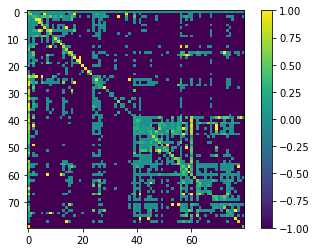

In [8]:
plt.imshow(success)
plt.colorbar()

In [9]:

for i in range(n):
    for j in range(n):
        if i == j and success[i,j] <= 0.5 and counts[i,j] >= 10:
            print(names[i])
        if i != j and success[i,j] >= 0.5 and counts[i,j] >= 10:
            print(names[i], names[j])
    

bicycle person
car
truck bus
traffic light
handbag person
handbag
tie person
tie
frisbee person
frisbee
skis person
skis
snowboard person
snowboard
sports ball person
sports ball
baseball bat person
baseball bat
baseball glove person
baseball glove
skateboard person
skateboard
surfboard
tennis racket person
tennis racket
bottle person
bottle
bottle dining table
bottle refrigerator
wine glass
cup
cup dining table
fork person
fork
fork dining table
knife person
knife
knife dining table
spoon person
spoon
spoon dining table
bowl
bowl dining table
broccoli
carrot bowl
carrot
carrot dining table
cake person
cake dining table
chair
couch person
couch
mouse
remote person
remote
keyboard
cell phone person
cell phone
microwave
oven
sink
book
clock
vase


Average Change  0.6875



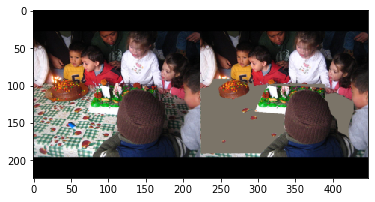

True True




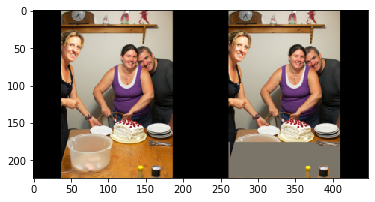

True True




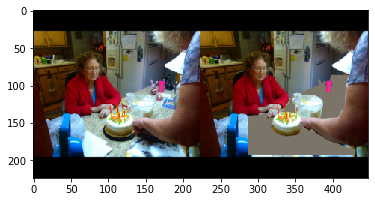

True False




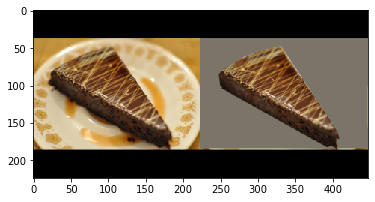

True False




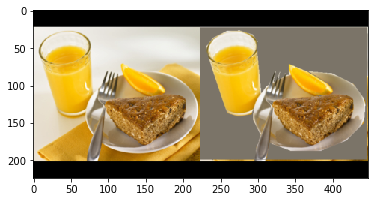

True True




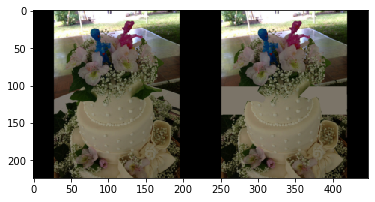

True True




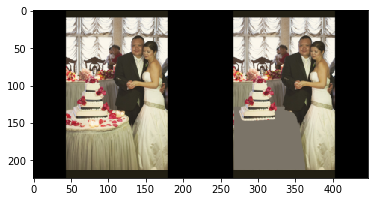

True False




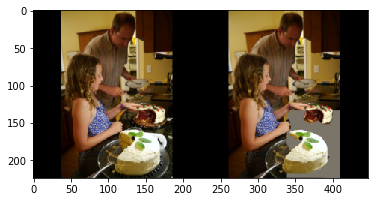

True True




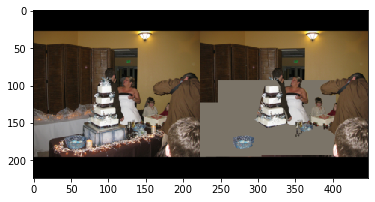

True False




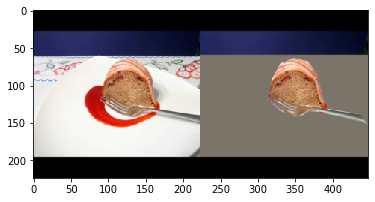

True False



In [10]:
model_class = 'cake'
index = getClassID(model_class)
labeler_classes = ['dining table']

mask_mode = 'box'
mask_unmask = True

ims, labels = run(model_class, labeler_classes, mask_mode = mask_mode, mask_unmask = mask_unmask)

print("Average Change ", 1.0 - np.mean(labels))

# Show the original and modified images and verify the predictions
for i in range(10):
    print()
    im_orig = load_img(ims[i], mask_apply = False)
    im_post = load_img(ims[i], mask_apply = True, mask_classes = labeler_classes, mask_mode = mask_mode, mask_unmask = mask_unmask)
    plt.show()
    plt.imshow(np.hstack((im_format(im_orig), im_format(im_post))))
    plt.show()
    print(predict(im_orig)[0, index] >= 0.5, predict(im_post)[0, index] >= 0.5)
    print()